In [1]:
# -*- coding: utf-8 -*-
import h5py
import numpy as np
import os
from PIL import Image
from scipy.misc import imread
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

In [2]:
# -----------precess the data------------------------
#读取h5文件
# read every h5_file, and check
img_data = []
lab_data = []
names = os.listdir('./data_process')
numimgs = len(names)
for i in np.arange(0, numimgs):
    fi = h5py.File('./data_process/{}'.format(names[i]), 'r')
    fi.keys()
    img = fi['image'][:]
    lab = fi['label'][:]
    print(fi.filename)
    print("img shape", img.shape)
    print('lab_one_hot', lab.shape)
    img_data.append(img)
    lab_data.append(lab)
    fi.close

#数据变换
# divide whole data, test the final image
numdata = len(img_data)
train_imgs, train_labs = img_data[:-1], lab_data[:-1]
test_imgs, test_labs = img_data[numdata // 2:], lab_data[numdata // 2:]
# the list of imgs/labs convert to [l*w, times, channels/classes]
train_imgs, train_labs = np.stack(train_imgs, 1), np.stack(train_labs, 1)
test_imgs, test_labs = np.stack(test_imgs, 1), np.stack(test_labs, 1)  # [N, list_len, 4]
print(train_imgs.shape, train_labs.shape)
print(test_imgs.shape,test_labs.shape)

./data_process/20150203ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20150611ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20150102ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20150510ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20151026ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20160206ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20151118ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20160325ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20150316ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20150915ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20160105ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20150604ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20151102ndvi.h5
img shape (65536, 1)
lab_one_hot (65536, 4)
./data_process/20150118nd

In [3]:
def next_batch(imgs, labs, batch_size):
    for i in range(imgs.shape[0] // batch_size - 1):
        batch_imgs = imgs[i * batch_size:(i + 1) * batch_size, :]
        batch_labs = labs[i * batch_size:(i + 1) * batch_size, :]
    return batch_imgs, batch_labs

In [4]:
learning_rate = 0.01
training_steps = 200
batch_size = int(65536/16)
display_step = 20

# network parameters
n_input = train_imgs[0].shape[1]  # channels of images
timesteps = test_steps = numdata // 2  # the timesteps of training = testing's
n_hidden = 128  # just random number (size of lstm cell)
n_classes = train_labs[0].shape[1]

X = tf.placeholder(tf.float32, [None, timesteps, n_input])
Y = tf.placeholder(tf.float32, [None, n_classes])

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes])),
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes])),
}
is_training = tf.placeholder(tf.bool)

def RNN(x, weights, biases,is_training):
    # current data(x) is (batch_size, timesteps, n_input) shape
    # need list of (batch_size, n_input) shape with size=timesteps
    x = tf.unstack(x, timesteps, 1)
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

    #outputs, state = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    #return tf.add(tf.matmul(outputs[-1], weights['out']), biases['out'])
    rnn_outputs, state = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    outputs = tf.add(tf.matmul(rnn_outputs[-1], weights['out']), biases['out'])
    batch_outputs = tf.layers.batch_normalization(outputs,training=is_training)
    return batch_outputs


logits = RNN(X, weights, biases,is_training)
prediction = tf.nn.softmax(logits)

loss_op = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()
fig_loss = np.zeros([training_steps])
acc_list = []

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Step 0, Minibatch Loss= 1.2901, Training Accuracy= 0.595
Step 20, Minibatch Loss= 0.3628, Training Accuracy= 0.922
Step 40, Minibatch Loss= 0.2151, Training Accuracy= 0.934
Step 60, Minibatch Loss= 0.1568, Training Accuracy= 0.945
Step 80, Minibatch Loss= 0.1293, Training Accuracy= 0.954
Step 100, Minibatch Loss= 0.1202, Training Accuracy= 0.957
Step 120, Minibatch Loss= 0.1105, Training Accuracy= 0.959
Step 140, Minibatch Loss= 0.1045, Training Accuracy= 0.959
Step 160, Minibatch Loss= 0.1033, Training Accuracy= 0.960
Step 180, Minibatch Loss= 0.0938, Training Accuracy= 0.963
Optimization finished!!!
Test accuracy is  0.8756256
生成标签维度 (65536,)


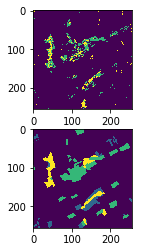

In [5]:
with tf.Session() as sess:
    sess.run(init)

    for step in range(training_steps):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)  
        with tf.control_dependencies(update_ops): #保证train_op在update_ops执行之后再执行。  
            train_op = optimizer.minimize(loss_op)
        # 固定时间步长“移动”训练
        for i in range(train_imgs.shape[1] - timesteps):
            batch_x, batch_y0 = next_batch(train_imgs[:, i:i + timesteps, :],
                                           train_labs[:, i:i + timesteps, :],
                                           batch_size)
            batch_y = batch_y0[:, -1, :]
            _, fig_loss[step], acc = sess.run([train_op, loss_op, accuracy],
                                              feed_dict={X: batch_x, Y: batch_y,is_training:True})
            acc_list.append(acc)

        if step % display_step == 0:
            loss, acc, pred = sess.run([loss_op, accuracy, prediction],
                                       feed_dict={X: batch_x, Y: batch_y,is_training:True})
            acc_list.append(acc)
            print("Step " + str(step) + ", Minibatch Loss= " +
                  "{:.4f}".format(loss) + ", Training Accuracy= " +
                  "{:.3f}".format(np.mean(acc_list)))
            acc_list = []
            # print('predict situation', np.max(np.argmax(pred, 1)))
            # print('gt situation', np.max(np.argmax(batch_y, 1)))

    print("Optimization finished!!!")

    # Test
    test_labs0 = test_labs[:, -1, :]
    print("Test accuracy is ", sess.run(accuracy,
                                        feed_dict={X: test_imgs, Y: test_labs0,is_training:False}))
    test_pre = sess.run(prediction, feed_dict={X: test_imgs, Y: test_labs0,is_training:False})
    pre_lab = np.argmax(test_pre, axis=1)
    print("生成标签维度", pre_lab.shape)
    plt.subplot(211)
    plt.imshow(pre_lab.reshape(256, 256))
    plt.subplot(212)
    plt.imshow(np.argmax(test_labs0, axis=1).reshape(256, 256))
    plt.show()

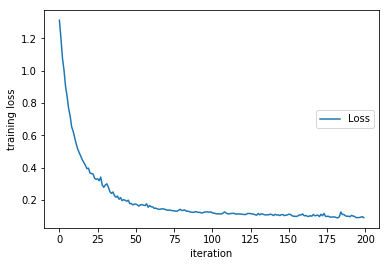

In [6]:
fig, ax1 = plt.subplots()
lns1 = ax1.plot(np.arange(training_steps), fig_loss, label="Loss")
ax1.set_xlabel('iteration')
ax1.set_ylabel('training loss')
labels = ["Loss"]
plt.legend(lns1, labels, loc=7)
plt.show()